In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import yaml
import matplotlib.pyplot as plt
import warnings
import numpy as np
import cv2

warnings.filterwarnings("ignore")

C:\Users\Tony\PycharmProjects\BrainCancerDetection\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
with open(r"../config.yaml", "r") as yml_config:
    cfg = yaml.load(yml_config, Loader=yaml.FullLoader)

image_size = cfg["image"]["image_size"]
batch_size = cfg["image"]["batch_size"]
figure_size = (20, 10)

### Visualizing some of the brain MRI scans

Found 639 files belonging to 2 classes.
['healthy', 'tumor']


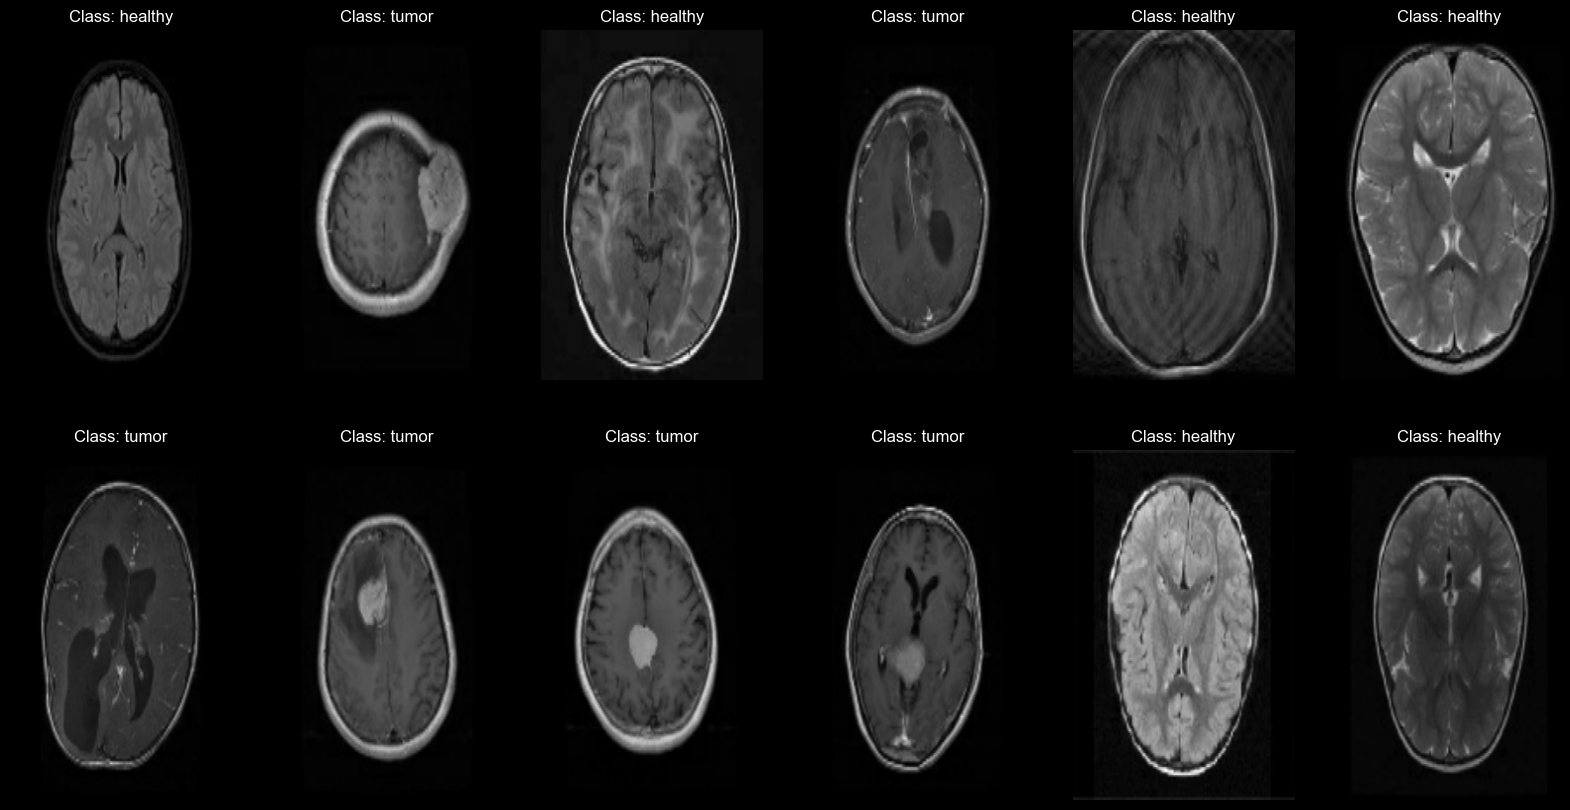

In [3]:
train_ds = image_dataset_from_directory(
    r"..\data\split\train",
    image_size=image_size,
    shuffle=True,
    batch_size=batch_size,
)

# Storing the classes
class_names = train_ds.class_names
print(class_names)


for images, labels in train_ds.take(1):
    plt.figure(figsize=figure_size)
    for _ in range(12):
        ax = plt.subplot(2, 6, _ + 1)
        plt.imshow(images[_].numpy().astype("uint8"), aspect="auto")
        class_name = train_ds.class_names[labels[_]]
        plt.title(f'Class: {class_name}')
        plt.axis('off')
    plt.show()

## Data Distribution

In [4]:
path = cfg['data'].get('split_data')
counts = {}
splits = os.listdir(path)

for split in splits:
    counts[split] = {}
    for cls in class_names:
        folder = os.path.join(path, split, cls)
        images = [image for image in os.listdir(folder) if image.lower().endswith((".jpg", ".jpeg", ".png"))]
        counts[split][cls] = len(images)

for key, val in counts.items():
    print(key, val)

test {'healthy': 41, 'tumor': 39}
train {'healthy': 326, 'tumor': 313}
val {'healthy': 41, 'tumor': 40}


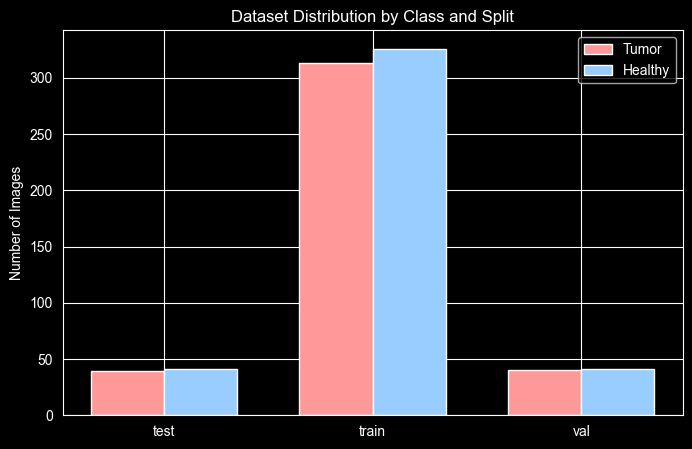

In [5]:
splits = list(counts.keys())
tumor_counts   = [counts[s]['tumor'] for s in splits]
healthy_counts = [counts[s]['healthy'] for s in splits]

#ploting To have a visual on the dataset
fig, ax = plt.subplots(figsize=(8,5))
bar_width = 0.35
x = range(len(splits))

ax.bar([i-bar_width/2 for i in x], tumor_counts, bar_width, label='Tumor', color='#FF9999')
ax.bar([i+bar_width/2 for i in x], healthy_counts, bar_width, label='Healthy', color='#99CCFF')

ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_ylabel("Number of Images")
ax.set_title("Dataset Distribution by Class and Split")
ax.legend()
plt.show()

# Data Pipeline

#### Resizing the dataset

In [6]:
import sys
sys.path.append(os.path.abspath(".."))

from src.data_loader import load_data
from utils.resizing import resizing_data

path = cfg['data'].get('split_data')
resizing_data(path)

800 images successfully resized


In [7]:
# Reloading the data
train_ds, test_ds, val_ds = load_data(path)

Found 639 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Found 81 files belonging to 2 classes.


#### Normalizing the dataset

In [8]:
# Normalizing the split dataset
from utils.normalizer import normalize_layers

train_ds = normalize_layers(train_ds)
test_ds = normalize_layers(test_ds)
val_ds = normalize_layers(val_ds)

for images, labes in train_ds.take(1):
    print(f'Pixel range: {tf.reduce_min(images).numpy()} - {tf.reduce_max(images).numpy()}')

Pixel range: 0.0 - 1.0


#### Augmentation

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])
# applying data Augmentation to the training dataset only
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

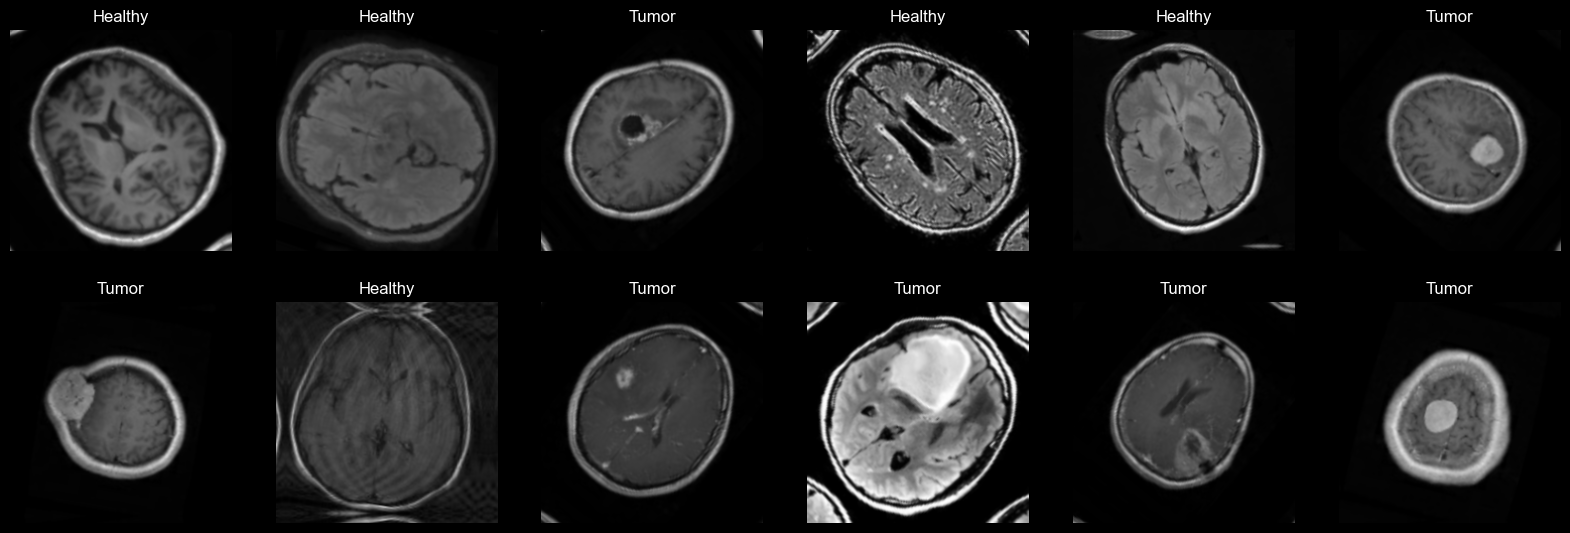

In [10]:
# plot for data augmented
for images, labels in train_ds.take(1):
    plt.figure(figsize=figure_size)
    for i in range(12):
        ax = plt.subplot(3,6,i+1)
        plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0).numpy())
        plt.title("Tumor" if labels[i].numpy()==1 else "Healthy")
        plt.axis("off")
    plt.show()


#### Pipeline optimization (cache, shuffle & prefetch)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE # Setting the Autotune value
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

In [12]:
for images, _ in train_ds.take(1):
    print(f"Shape of Training data: {tf.shape(images)}")

Shape of Training data: [ 32 224 224   3]


In [13]:
model =  keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    # layers.MaxPooling2D(pool_size=(2, 2)),

    # Dense fully connected layer with 128 neurons
    # layers.Flatten(), #converting the 2D features into 1D vector
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),

    # Dropout randomly drops 50% of neurons to prevent overfitting
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') # for binary classification
])

# Model compilation

In [14]:
model.compile(
    optimizer='adam', #
    loss='binary_crossentropy', # For binary classification
    metrics=['accuracy']
)

# Model Training

In [15]:
train_history = model.fit(
    train_ds,   # on augmented dataset
    validation_data=val_ds, # Not augmented
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5), # stopping if the performance is not going up after 5 epoches
               keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True), # saving the best model
               keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)]
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5180 - loss: 0.6885 - val_accuracy: 0.5432 - val_loss: 0.6759
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6854 - loss: 0.6587 - val_accuracy: 0.8272 - val_loss: 0.5909
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7668 - loss: 0.5690 - val_accuracy: 0.8272 - val_loss: 0.4860
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7700 - loss: 0.5296 - val_accuracy: 0.8272 - val_loss: 0.4661
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7997 - loss: 0.5184 - val_accuracy: 0.7531 - val_loss: 0.4761
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7762 - loss: 0.5110 - val_accuracy: 0.8519 - val_loss: 0.4292
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8153 - loss: 0.4598 - val_accuracy: 0.8519 - val_loss: 0.4229
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7793 - loss: 0.4822 - val_accuracy: 0.8025 - val_loss:

In [16]:
tes_loss , test_acc = model.evaluate(test_ds)
print(f'Accuracy test: {test_acc}\nLoss test: {tes_loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.8750 - loss: 0.3174
Accuracy test: 0.875
Loss test: 0.31744131445884705


In [21]:
history = train_history.history
for key, val in history.items():
    print(key)

accuracy
loss
val_accuracy
val_loss


#### First training plot

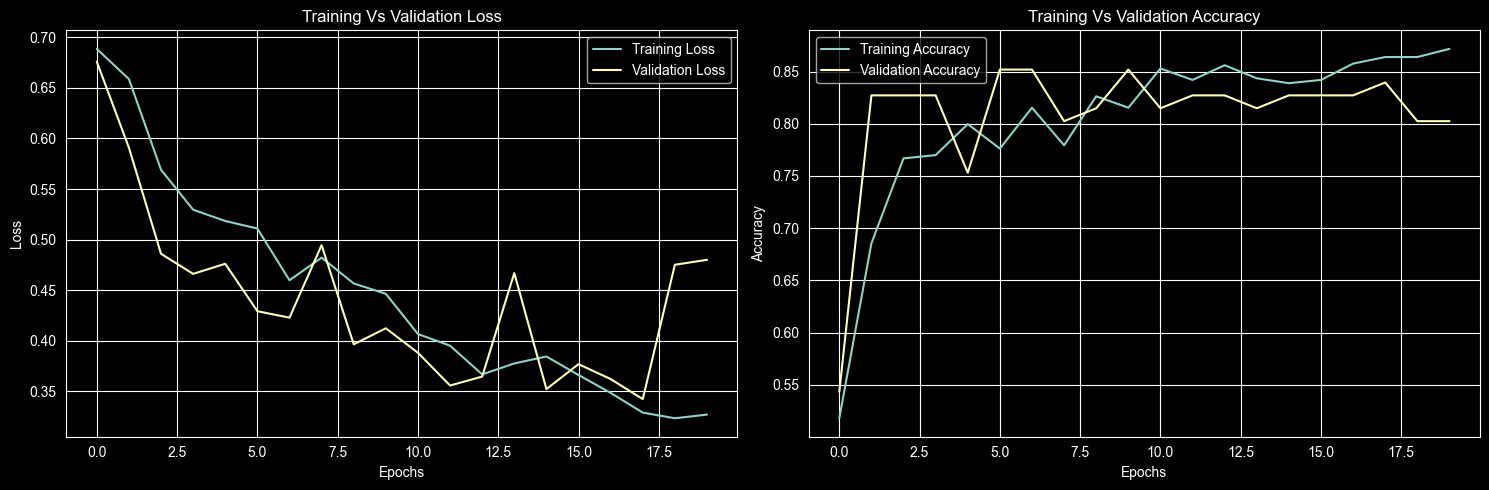

In [32]:
from src.plotting import history_plot
history_plot(history)

## CURVES INTERPRETATION
### Loss Curves

- Both training and validation loss decreasing → Model is learning well.
- Training loss keeps decreasing but validation loss starts increasing → Overfitting (model memorizing training data instead of generalizing).
- Loss plateaus → Learning rate might be too low, or model has reached its capacity.

### Accuracy Curves (or other metrics)

- Both training and validation accuracy increasing together → Good learning progress.
- Training accuracy high, validation accuracy stagnant or dropping → Overfitting.
- Both accuracies low → Underfitting (model too simple or not trained enough).

# Model Tuning

#### Applying new data augmentation

In [34]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model_v2 = load_model('best_model.keras')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    brightness_range=[.7, 1.8],
    horizontal_flip=True
)
# Reapplying data augmentation
tune_train_ds = train_datagen.flow_from_directory(
    r"..\data\split\train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 639 images belonging to 2 classes.


#### Tune model compilation and training

In [40]:
# reducing learning speed
model_v2.compile(optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'], loss='binary_crossentropy')
train_history_mv2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3),
               keras.callbacks.ModelCheckpoint("model_v2.keras", save_best_only=True),]
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8482 - loss: 0.3747 - val_accuracy: 0.8272 - val_loss: 0.3451
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8717 - loss: 0.3385 - val_accuracy: 0.8272 - val_loss: 0.4132
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8717 - loss: 0.3181 - val_accuracy: 0.8519 - val_loss: 0.3267
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8905 - loss: 0.2961 - val_accuracy: 0.8395 - val_loss: 0.3658
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8748 - loss: 0.3095 - val_accuracy: 0.8519 - val_loss: 0.3316
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8905 - loss: 0.2975 - val_accuracy: 0.8395 - val_loss: 0.3146
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8842 - loss: 0.2986 - val_accuracy: 0.8272 - val_loss: 0.4130
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8419 - loss: 0.3522 - val_accuracy: 0.8148 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8750 - loss: 0.3174
Model_v2 Accuracy: 0.875
Loss test: 0.31744131445884705


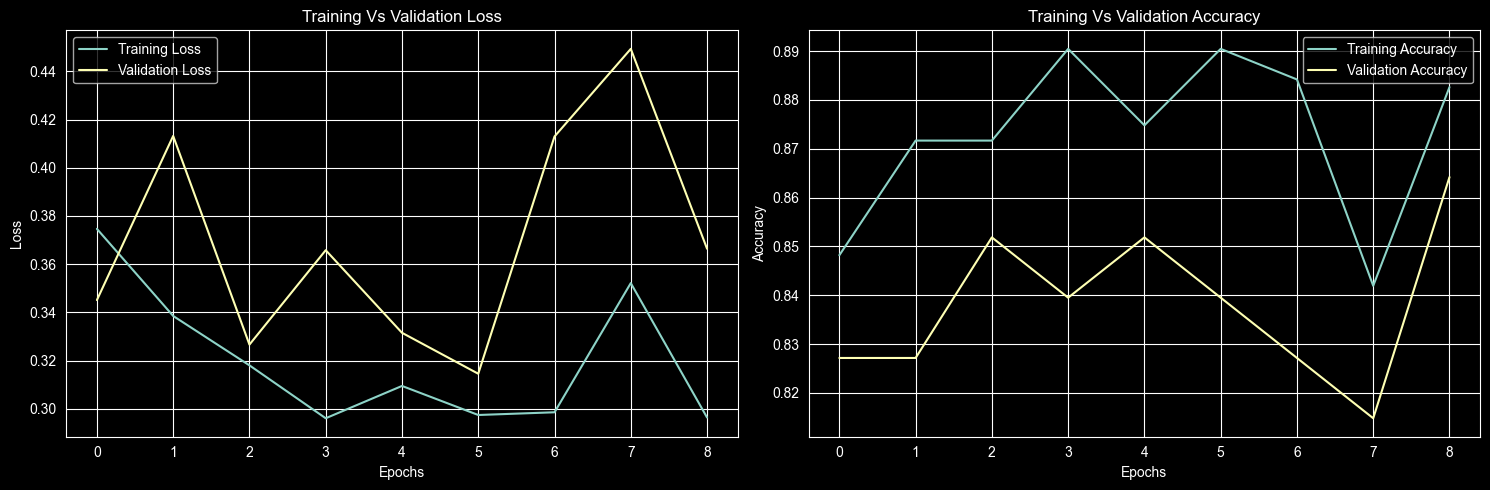

In [42]:
mv2_loss, mv2_acc = model_v2.evaluate(test_ds)
print(f'Model_v2 Accuracy: {mv2_acc}\nLoss test: {mv2_loss}')

history_plot(train_history_mv2.history)